In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from time import time

In [2]:
def d1(St, K, T, t, r, q, sigma):
    return (np.log(St/K) + (r -q + sigma**2/2)*(T-t))/(sigma*np.sqrt(T - t))

def d2(St, K, T, t, r, q, sigma):
    return (np.log(St/K) + (r - q - sigma**2/2)*(T-t))/(sigma*np.sqrt(T - t))

def BSMcall(St, K, T, t, r, q, sigma):
    """
    St: Stock price at time t
    t: reference time
    T: time to maturity
    r: risk free rate
    q : dividend rate
    sigma: volatility
    """
    _d1 = sp.special.ndtr(d1(St, K, T, t, r, q, sigma))
    _d2 = sp.special.ndtr(d2(St, K, T, t, r, q, sigma))

    return St*np.exp(-q*(T-t))*_d1 - K*np.exp(-r*(T-t))*_d2

def BSMdigitalCall(St, K, T, t, r, q, sigma):
    return np.exp(-r*(T-t))*sp.special.ndtr(d2(St, K, T, t, r, q, sigma))

def BSMput(St, K, T, t, r, q, sigma):
    _d1 = sp.special.ndtr(-d1(St, K, T, t, r, q, sigma))
    _d2 = sp.special.ndtr(-d2(St, K, T, t, r, q, sigma))

    return K*np.exp(-r*(T-t))*_d2 - St*np.exp(-q*(T-t))*_d1

In [3]:
def OneDGBMPathGenerator(N_paths,S0,T,r,q,sigma, W):
    """
    N_paths : number of paths
    S0: initial stock price
    T : maturity
    r : risk free interest rate
    q : divident rate
    sigma : stock volatility
    W : random number array
    """
    return S0*np.exp((r-q-sigma**2/2)*np.repeat(np.array([T]),N_paths) + sigma*np.sqrt(T)*W)

In [4]:
def GBMPathGenerator(n_steps,n_paths,S0,T,r,q,sigma, Z):
    """
    n_steps : dimensionality / number of increments
    n_paths : number of paths
    S0: initial stock price
    T : maturity
    r : risk free interest rate
    q : divident rate
    sigma : stock volatility
    Z : the standard Wiener process
    """
    times = np.linspace(0., T, n_steps)
    timesArray = np.repeat(times.reshape(n_steps,1), n_paths, axis = 1)
    S = S0*np.exp((r-q-sigma**2/2)*timesArray + sigma*Z)
    return S

def WienerProcessGenerator(n_steps, n_paths, T):
    dt = T/(n_steps-1)
    # Wt2 - Wt1 ~ Normal with mean 0 and variance t2-t1
    dW = np.zeros((n_steps, n_paths))
    dW[1:, :] = np.sqrt(dt) * np.random.normal(size=(n_steps-1, n_paths))
    # Simulation of Arithmetic brownian motion
    W = np.cumsum(dW, axis=0)
    return W

## **First task**

**Build an analytic pricer for arrears FRA**



Start with the payoff function of an arrears FRA

$$
FRA^{arrears} = E[(f-K)(1+f(T_1-T_0))]P(0,T_1)(T_1-T_0)
$$

Consider $f$ driftless log normal as we pick $P(T_1)$ zero-coupon bond as numeraire. This means we can write

$$
df = f \sigma dW
$$

or

$$
f = f_0e^{-\frac{1}{2}\sigma^2t + \sigma W(t)}
$$

Expressed differently

$$
f = f_0e^Y,
$$

where $Y$ is an arithmetic Brownian Motion with SDE(stochastic differential equation)

$$
dY = -\frac{1}{2}\sigma^2 dt + \sigma dW,
$$

with $Y(T=0) = Y_0$, $E[Y] = Y_0 -\frac{1}{2}\sigma^2t$ and $Var[Y] =\sigma ^2 t$

We know from the properties of Geometric Brownian Motion that

$$
E[e^{Y}] = e^{E[Y] + \frac{1}{2}Var[Y]},
$$

where $Y$ is an arithmetic Brownian Motion whic thus gives

$$
E[e^{Y}] = e^{Y_0 -\frac{1}{2}\sigma^2t + \frac{1}{2}\sigma^2t} = e^{Y_0}.
$$

This confirms that the driftless log normal forward rate $f$ is indeed a martingale.

In oder to compute $f$ at $T_0$ when they payment is made we need the expectation value of $E[f]$ at $T_0$.

Our initial conditions are $f_0$ at $T = 0$, volatility $\sigma$, strike $K$, start date of the arrears FRA contract $T_0$ ($T_0 \neq 0$ !!) and final date $T_1$ and $P(0,T_1)$.

Thus

$$
E[f] = f_0
$$

and in the case of $f^2$ the associated arithmetic Brownian Motion will simply be $Y^{\prime} = 2 \cdot Y$ with $E[Y^{\prime}] = 2Y_0-\sigma^2t$ and $Var[Y^{\prime}] = 4 \sigma^2 t$. Thus, by applying the above property of GBM we get

$$
E[f^2] = f_0^2 e^{\sigma^2 t}.
$$

Then the analytical formula for the payoff of the arrears FRA is

$$
FRA^{arrears} = \big[ f_0 - K + f_0^2 e^{\sigma^2 T_0} (T_1-T_0) - f_0K(T_1-T_0) \big] P(0,T_1) (T_1-T_0)
$$

## The bond expiring at $T_1$ is used as numeraire

In [5]:
def analyticArrearsFRA(f0,K,T0,T1,PT1,sigma):
    return (f0 - K + f0**2*np.exp(sigma**2*T0)*(T1-T0)- f0*K*(T1-T0))*PT1*(T1-T0)

## **Second Task**

**Numeric integration pricer for the arrears FRA**

Numerical integration is performed by referring to the integral form of the expectation function. What we need is $E[C]$ at $T_0$ where $C$ is the payoff.

Then

$$
E[C] = ∫ pdf(C) C dC,
$$

and

$$
C = E[(f-K)(1+f(T_1-T_0))]P(0,T_1)(T_1-T_0).
$$


Again, we know about f


$$
df = f \sigma dW
$$

or

$$
f = f_0e^{-\frac{1}{2}\sigma^2t + \sigma W(t)}
$$

or
$$
f = f_0e^Y,
$$

where $Y$ is an arithmetic Brownian Motion with SDE(stochastic differential equation)

$$
dY = -\frac{1}{2}\sigma^2 dt + \sigma dW,
$$

with $Y(T=0) = Y_0$, $E[Y] = Y_0 -\frac{1}{2}\sigma^2t$ and $Var[Y] =\sigma ^2 t$

and that the 1 point probability density function is

$$
P(y,t) = \frac{1}{\sqrt{2\pi t \sigma^2}} e^{-\frac{(y - E[y,t])^2}{2 \sigma^2 t}}
$$

Thus


$$
E[C] = ∫ C(y) \frac{1}{\sqrt{2\pi t \sigma^2}} e^{-\frac{(y - E[y,t])^2}{2 \sigma^2 t}} dy,
$$


By taking a cutoff really far from the mean we can get to a reasonable approximation of the correct answer.

The arrears FRA integrand is

$$
(e^y - K)(1+e^y*(T1-T0)) \cdot \frac{1}{\sqrt{2\pi T_0 \sigma^2}} e^{-\frac{(y - (Y_0 - \frac{1}{2}\sigma^2T_0))^2}{2 \sigma^2 T_0}}
$$

In [6]:
def arrearsFRAIntegrand(y, y0, K, T1, T0, sigma):
    a = (1/np.sqrt(2*np.pi*T0*sigma**2))*(T1-T0)
    b = (np.exp(y)-K)*(1+np.exp(y)*(T1-T0))
    c = np.exp(-(y - (y0 - 0.5*sigma**2*T0))**2/(2*sigma**2*T0))
    return a*b*c


In [7]:
f0 = .06 # Initial forward rate of the FRA contract between T0 & T1
K = .07 # Strike for the FRA
T0 = 10 # Start time of the FRA contract
T1 = 10 + 0.5 # End time of the FRA contract
PT0 = 0.5 # Bond expiring at T0 price
PT1 = PT0/(1+f0*(T1-T0)) # Bond expiring at T1 price
sigma = .2 # Volatility of forward rate

In [8]:
# NUMERIC INTEGRATION FOR ARREARS FRA

N = 100 # The number of intervals in the integration domain
y0 = np.log(f0) # Log of initial forward rate
Lambda = 10*sigma*np.sqrt(T0) # The cutoff factor, Lambda, is chosen a multiplier of the standard deviation
yT0 = y0 - .5*sigma**2*T0 # Helper variable / Expectation value of Y process at T0 - Arithmetic Brownian Motion
yArray = np.linspace(yT0-Lambda, yT0 + Lambda, N)
dy = yArray[1]-yArray[0]
numericIntegrFRA = np.sum(arrearsFRAIntegrand(y = yArray, y0 = y0, K = K, T1 = T1 ,T0 = T0, sigma = sigma)*dy)*PT1

In [9]:
_analyticFRAArrears = analyticArrearsFRA(f0,K,T0,T1,PT1,sigma)

In [10]:
FRAArrearsdiscrepancy = (numericIntegrFRA - _analyticFRAArrears)/_analyticFRAArrears
print(f'The discrepancy of Numerical FRA Arrears to analytical FRA Arrears price is {FRAArrearsdiscrepancy*100:.2f} %')

The discrepancy of Numerical FRA Arrears to analytical FRA Arrears price is -0.00 %


## **Third task**

**Numeric integration pricer for Arrears Caplet**

Using the previous integral form of the Expectation Function, we find the following integrand for the arrears caplet

$$
(e^y - K)_+(1+e^y*(T1-T0)) \cdot \frac{1}{\sqrt{2\pi T_0 \sigma^2}} e^{-\frac{(y - (Y_0 - \frac{1}{2}\sigma^2T_0))^2}{2 \sigma^2 T_0}}
$$

In [11]:
def arrearsCapletIntegrand(y, y0, K, T1, T0, sigma):
    a = (1/np.sqrt(2*np.pi*T0*sigma**2))*(T1-T0)
    b = np.maximum((np.exp(y)-K),0)*(1+np.exp(y)*(T1-T0))
    c = np.exp(-(y - (y0 - 0.5*sigma**2*T0))**2/(2*sigma**2*T0))
    return a*b*c


In [12]:
numericArrearsCaplet = np.sum(arrearsCapletIntegrand(y = yArray, y0 = y0, K = K, T1 = T1 ,T0 = T0, sigma = sigma)*dy)*PT1

## **Fourth task**

##**Monte carlo pricer for FRA**



The forward rate is driftless when the bond expiring at $T_1$ is used as numeraire

In [13]:
f0 = .06 # Initial forward rate of the FRA contract between T0 & T1
K = .07 # Strike for the FRA
T0 = 10 # Start time of the FRA contract
T1 = 10 + 0.5 # End time of the FRA contract
PT0 = 0.5 # Bond expiring at T0 price
PT1 = PT0/(1+f0*(T1-T0)) # Bond expiring at T1 price
sigma = .2 # Volatility of forward rate

In [14]:
def arrearsFRApayoff(f,K,T1, T0, PT1):
    return (f-K)*(T1-T0)*PT1*(1+f*(T1-T0))

In [18]:
minPower = 4
maxPower = 17
pathsArray = np.power(2,np.arange(minPower,maxPower))

In [19]:
MC_ArrearsFRApricer = np.zeros((maxPower-minPower))
MC_ArrearsFRApricerStd = np.zeros((maxPower-minPower))
for idx, N_paths in enumerate(pathsArray):

    W = np.random.normal(size=N_paths)
    f = OneDGBMPathGenerator(N_paths = N_paths, S0 = f0, T= T0, r = 0, q = 0, sigma = sigma, W = W)
    MC_ArrearsFRApricer[idx] = np.mean((f-K)*(T1-T0)*PT1*(1+f*(T1-T0)))
    MC_ArrearsFRApricerStd[idx] = np.std((f-K)*(T1-T0)*PT1*(1+f*(T1-T0)))/np.sqrt(N_paths)

analytic_FRAarrears = analyticArrearsFRA(f0 = f0,K = K,T0 = T0, T1 = T1, PT1 = PT1, sigma = sigma)

Using parameters: sigma = 0.20, T0 = 10.00 years, T1 = 10.50 years, K = 0.07


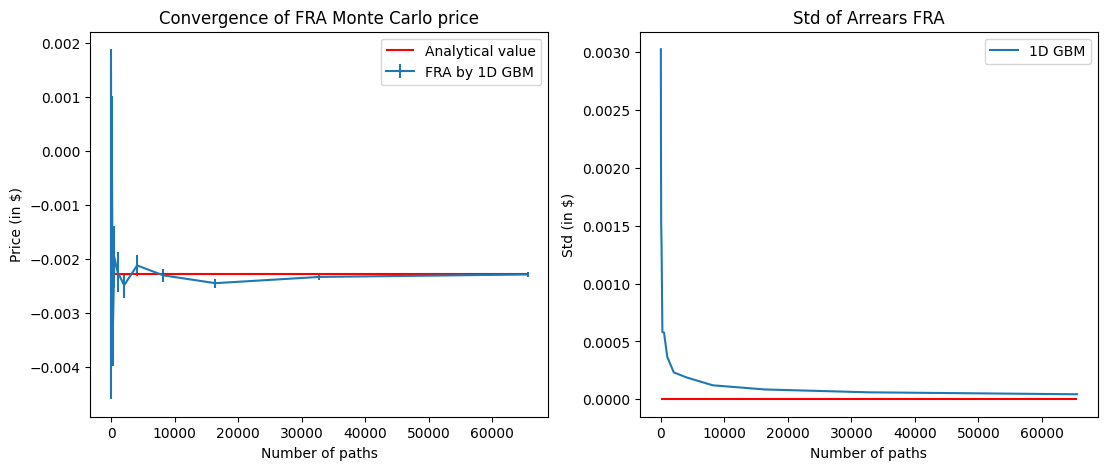

In [20]:
print(f'Using parameters: sigma = {sigma:.2f}, T0 = {T0:.2f} years, T1 = {T1:.2f} years, K = {K:.2f}')
fig,ax = plt.subplots(1,2, figsize=(13,5))

ax[0].errorbar(pathsArray, MC_ArrearsFRApricer, yerr = MC_ArrearsFRApricerStd, label = f'FRA by 1D GBM')
ax[1].plot(pathsArray, MC_ArrearsFRApricerStd, label = "1D GBM")

ax[0].set_title('Convergence of FRA Monte Carlo price')
ax[0].set_xlabel('Number of paths')
ax[0].hlines(xmin = pathsArray[0], xmax = pathsArray[-1], y =analytic_FRAarrears, color = 'red', label='Analytical value')
ax[0].legend()
ax[0].set_ylabel(r'Price (in \$)')
ax[1].set_title('Std of Arrears FRA')
ax[1].set_xlabel('Number of paths')
ax[1].set_ylabel(r'Std (in \$)')
ax[1].hlines(y=0, color = 'red', xmin =0, xmax = np.power(2,maxPower-1))
ax[1].legend()
fig.show()

In [21]:
MC_FRAArrearsdiscrepancy = (MC_ArrearsFRApricer[-1] - _analyticFRAArrears)/_analyticFRAArrears
print(f'The discrepancy of Monte Carlo FRA Arrears to analytical FRA Arrears price is {MC_FRAArrearsdiscrepancy*100:.2f} %')

The discrepancy of Monte Carlo FRA Arrears to analytical FRA Arrears price is 0.07 %


##**Monte Carlo for caplet**

In [28]:
def arrearsCapletPayoff(f,K,T1, T0, PT1):
    return np.maximum((f-K),0)*(T1-T0)*(1+f*(T1-T0))*PT1

In [24]:
MC_ArrearsCapletpricer = np.zeros((maxPower-minPower))
MC_ArrearsCapletpricerStd = np.zeros((maxPower-minPower))
for idx, N_paths in enumerate(pathsArray):

    W = np.random.normal(size=N_paths)
    f = OneDGBMPathGenerator(N_paths = N_paths, S0 = f0, T= T0, r = 0, q = 0, sigma = sigma, W = W)
    MC_ArrearsCapletpricer[idx] = np.mean(arrearsCapletPayoff(f =f,K=K,T1 = T1,T0 = T0,PT1 = PT1))
    MC_ArrearsCapletpricerStd[idx] = np.std(arrearsCapletPayoff(f =f,K=K,T1 = T1,T0 = T0,PT1 = PT1))/np.sqrt(N_paths)

numericArrearsCaplet = np.sum(arrearsCapletIntegrand(y = yArray, y0 = y0, K = K, T1 = T1 ,T0 = T0, sigma = sigma)*dy)*PT1

Using parameters: sigma = 0.20, T0 = 10.00 years, T1 = 10.50 years, K = 0.07


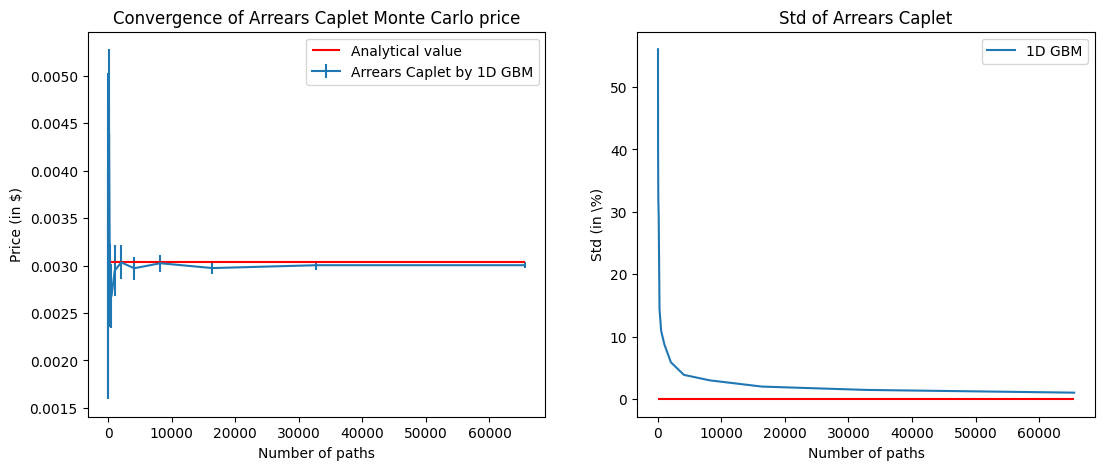

In [25]:
print(f'Using parameters: sigma = {sigma:.2f}, T0 = {T0:.2f} years, T1 = {T1:.2f} years, K = {K:.2f}')
fig,ax = plt.subplots(1,2, figsize=(13,5))

ax[0].errorbar(pathsArray, MC_ArrearsCapletpricer, yerr = MC_ArrearsCapletpricerStd, label = f'Arrears Caplet by 1D GBM')
ax[1].plot(pathsArray, 100*MC_ArrearsCapletpricerStd/numericArrearsCaplet, label = "1D GBM")

ax[0].set_title('Convergence of Arrears Caplet Monte Carlo price')
ax[0].set_xlabel('Number of paths')
ax[0].hlines(xmin = pathsArray[0], xmax = pathsArray[-1], y =numericArrearsCaplet , color = 'red', label='Analytical value')
ax[0].legend()
ax[0].set_ylabel(r'Price (in \$)')
ax[1].set_title('Std of Arrears Caplet')
ax[1].set_xlabel('Number of paths')
ax[1].set_ylabel(r'Std (in \%)')
ax[1].hlines(y=0, color = 'red', xmin =0, xmax = np.power(2,maxPower-1))
ax[1].legend()
fig.show()

In [26]:
numericArrearsCaplet = np.sum(arrearsCapletIntegrand(y = yArray, y0 = y0, K = K, T1 = T1 ,T0 = T0, sigma = sigma)*dy)*PT1
MC_ArrearsCapletdiscrepancy = (MC_ArrearsCapletpricer[-1] - numericArrearsCaplet)/numericArrearsCaplet
print(f'The discrepancy of Monte Carlo Arrears Caplet to numeric Arrears Caplet price is {MC_ArrearsCapletdiscrepancy*100:.2f} %')

The discrepancy of Monte Carlo Arrears Caplet to numeric Arrears Caplet price is -1.24 %


# Using different numeraires

##Use $P(T_0)$ as Bond numeraire

#First, naively use the same log normal shape of the forward rate
**However, we know that using $P(T_0)$ as numeraire leads to the forward rate to have a drift**

Because of this, we should notice a negative bias, because of lack of drift

In [30]:
minPower = 9
maxPower = 15
pathsArray = np.power(2,np.arange(minPower,maxPower))

In [31]:
MC_ArrearsFRApricer_PT0 = np.zeros((maxPower-minPower))
MC_ArrearsFRApricer_PT0_Std = np.zeros((maxPower-minPower))
for idx, N_paths in enumerate(pathsArray):

    W = np.random.normal(size=N_paths)
    f = OneDGBMPathGenerator(N_paths = N_paths, S0 = f0, T= T0, r = 0, q = 0, sigma = sigma, W = W)
    #   MC_ArrearsFRApricer[i,idx] = np.mean((f-K)*(T1-T0)*PT1*(1+f*(T1-T0))) # Using PT1 as numeraire
    MC_ArrearsFRApricer_PT0[idx] = np.mean((f-K)*(T1-T0))*PT0 # Using PT0 as numeraire
    MC_ArrearsFRApricer_PT0_Std[idx] = np.std((f-K)*(T1-T0)*PT0)/np.sqrt(N_paths)

analytic_FRAarrears = analyticArrearsFRA(f0 = f0,K = K,T0 = T0, T1 = T1, PT1 = PT1, sigma = sigma)

Using parameters: sigma = 0.20, T0 = 10.00 years, T1 = 10.50 years, K = 0.07


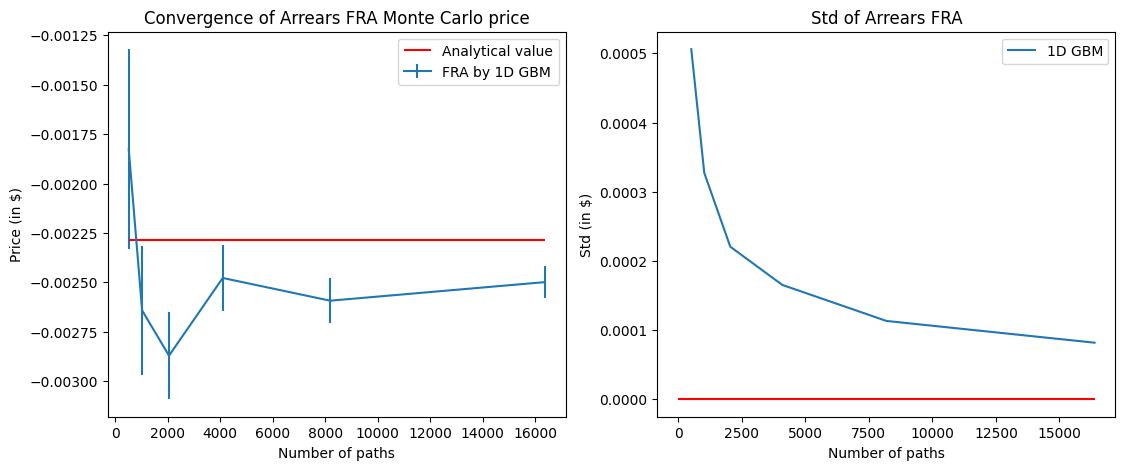

In [32]:
print(f'Using parameters: sigma = {sigma:.2f}, T0 = {T0:.2f} years, T1 = {T1:.2f} years, K = {K:.2f}')
fig,ax = plt.subplots(1,2, figsize=(13,5))

ax[0].errorbar(pathsArray, MC_ArrearsFRApricer_PT0, yerr = MC_ArrearsFRApricer_PT0_Std, label = f'FRA by 1D GBM')
ax[1].plot(pathsArray, MC_ArrearsFRApricer_PT0_Std, label = "1D GBM")

ax[0].set_title('Convergence of Arrears FRA Monte Carlo price')
ax[0].set_xlabel('Number of paths')
ax[0].hlines(xmin = pathsArray[0], xmax = pathsArray[-1], y =analytic_FRAarrears, color = 'red', label='Analytical value')
ax[0].legend()
ax[0].set_ylabel(r'Price (in \$)')
ax[1].set_title('Std of Arrears FRA')
ax[1].set_xlabel('Number of paths')
ax[1].set_ylabel(r'Std (in \$)')
ax[1].hlines(y=0, color = 'red', xmin =0, xmax = np.power(2,maxPower-1))
ax[1].legend()
fig.show()

Indeed, the negative bias is clear

## Use the Predictor Corrector Method for inferring the drift

In [19]:
from tqdm import tqdm

In [17]:
def predictorCorrectorForwardRate(f0,K,T0,T1,PT0,sigma, Nsteps, Npaths):
    f = np.zeros((Nsteps,Npaths))
    f[0,:] = f0*np.ones(Npaths)
    dt = T0/(Nsteps-1)
    old_drift = np.zeros(Npaths)
    new_drift = np.zeros(Npaths)
    newForwardRate = np.zeros(Npaths)
    tau = T1-T0

    W = np.random.normal(size=(Nsteps,Npaths))

    for tidx in range(1,Nsteps):

        newForwardRate = f[tidx-1,:]*np.exp((old_drift - .5*sigma**2)*dt + sigma*np.sqrt(dt)*W[tidx-1,:])
        curr_drift = sigma**2*tau*newForwardRate/(1+tau*newForwardRate)
        new_drift = (curr_drift+old_drift)/2
        newForwardRate = f[tidx-1,:]*np.exp((new_drift - .5*sigma**2)*dt + sigma*np.sqrt(dt)*W[tidx-1,:])

        f[tidx,:] = newForwardRate
        old_drift = new_drift

    return f


In [26]:
minPower = 4
maxPower = 12
N_paths = int(1e5)
pathsArray = np.power(2,np.arange(minPower,maxPower))
analytic_FRAarrears = analyticArrearsFRA(f0 = f0,K = K,T0 = T0, T1 = T1, PT1 = PT1, sigma = sigma)

In [27]:
MC_ArrearsFRApricer_PT0 = np.zeros((maxPower-minPower))
MC_ArrearsFRApricer_PT0_Std = np.zeros((maxPower-minPower))
MC_ArrearsCapletpricer_PT0 = np.zeros((maxPower-minPower))
MC_ArrearsCapletpricer_PT0_Std = np.zeros((maxPower-minPower))
for idx, Nsteps in tqdm(enumerate(pathsArray)):

    f = predictorCorrectorForwardRate(f0,K,T0,T1,PT0,sigma, Nsteps,N_paths)
    MC_ArrearsFRApricer_PT0[idx] = np.mean((f[-1,:]-K)*(T1-T0))*PT0 # Using PT0 as numeraire
    MC_ArrearsFRApricer_PT0_Std[idx] = np.std((f[-1,:]-K)*(T1-T0)*PT0)/np.sqrt(N_paths)
    MC_ArrearsCapletpricer_PT0[idx] = np.mean(np.maximum(f[-1,:]-K,0))*(T1-T0)*PT0
    MC_ArrearsCapletpricer_PT0_Std[idx] = np.std(np.maximum(f[-1,:]-K,0)*(T1-T0)*PT0)/np.sqrt(N_paths)

8it [00:29,  3.64s/it]


Using parameters: sigma = 0.20, T0 = 10.00 years, T1 = 10.50 years, K = 0.07


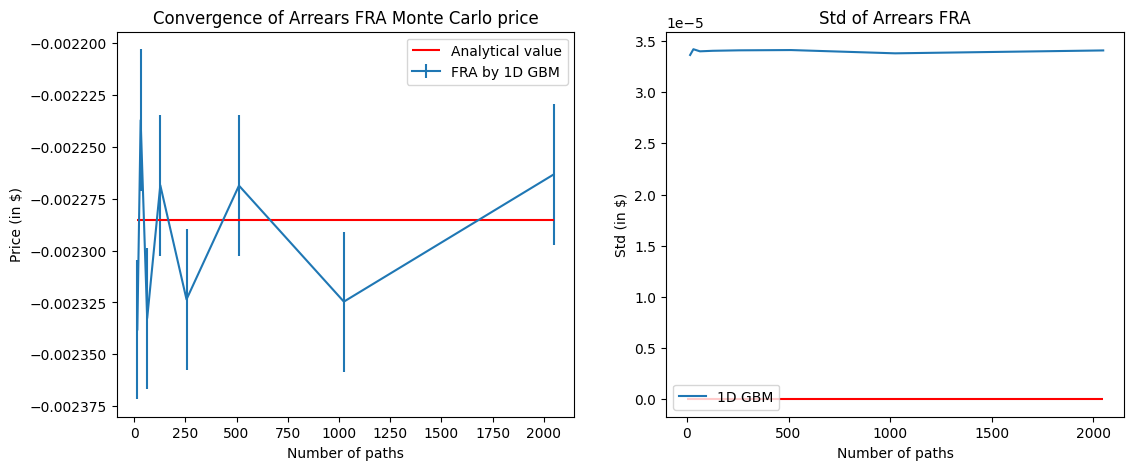

In [28]:
print(f'Using parameters: sigma = {sigma:.2f}, T0 = {T0:.2f} years, T1 = {T1:.2f} years, K = {K:.2f}')
fig,ax = plt.subplots(1,2, figsize=(13,5))

ax[0].errorbar(pathsArray, MC_ArrearsFRApricer_PT0, yerr = MC_ArrearsFRApricer_PT0_Std, label = f'FRA by 1D GBM')
ax[1].plot(pathsArray, MC_ArrearsFRApricer_PT0_Std, label = "1D GBM")

ax[0].set_title('Convergence of Arrears FRA Monte Carlo price')
ax[0].set_xlabel('Number of paths')
ax[0].hlines(xmin = pathsArray[0], xmax = pathsArray[-1], y =analytic_FRAarrears, color = 'red', label='Analytical value')
ax[0].legend()
ax[0].set_ylabel(r'Price (in \$)')
ax[1].set_title('Std of Arrears FRA')
ax[1].set_xlabel('Number of paths')
ax[1].set_ylabel(r'Std (in \$)')
ax[1].hlines(y=0, color = 'red', xmin =0, xmax = np.power(2,maxPower-1))
ax[1].legend()
fig.show()

Using parameters: sigma = 0.20, T0 = 10.00 years, T1 = 10.50 years, K = 0.07


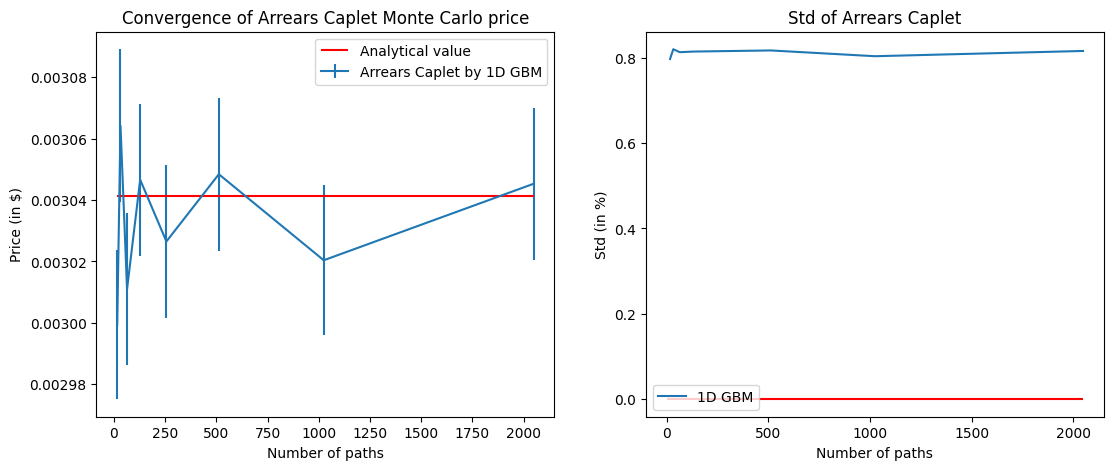

In [29]:
print(f'Using parameters: sigma = {sigma:.2f}, T0 = {T0:.2f} years, T1 = {T1:.2f} years, K = {K:.2f}')
fig,ax = plt.subplots(1,2, figsize=(13,5))

ax[0].errorbar(pathsArray, MC_ArrearsCapletpricer_PT0, yerr = MC_ArrearsCapletpricer_PT0_Std, label = f'Arrears Caplet by 1D GBM')
ax[1].plot(pathsArray, MC_ArrearsCapletpricer_PT0_Std*100/numericArrearsCaplet, label = "1D GBM")

ax[0].set_title('Convergence of Arrears Caplet Monte Carlo price')
ax[0].set_xlabel('Number of paths')
ax[0].hlines(xmin = pathsArray[0], xmax = pathsArray[-1], y =numericArrearsCaplet, color = 'red', label='Analytical value')
ax[0].legend()
ax[0].set_ylabel(r'Price (in \$)')
ax[1].set_title('Std of Arrears Caplet')
ax[1].set_xlabel('Number of paths')
ax[1].set_ylabel(r'Std (in %)')
ax[1].hlines(y=0, color = 'red', xmin =0, xmax = np.power(2,maxPower-1))
ax[1].legend()
fig.show()

The estimate is dominated by the Monte Carlo Noise

The time discretization bias seems to be smaller

Nevertheless, all estimates hug the analytical value, suggesting the Predictor corrector method got rid of the negative bias

Checking how the number of paths affect the estimate

In [40]:
Nsteps = 100
minPower = 12
maxPower = 17
pathsArray = np.power(2,np.arange(minPower,maxPower))

MC_ArrearsCapletpricer_PT0 = np.zeros((maxPower-minPower))
MC_ArrearsCapletpricer_PT0_Std = np.zeros((maxPower-minPower))
for idx, N_paths in tqdm(enumerate(pathsArray)):

    f = predictorCorrectorForwardRate(f0,K,T0,T1,PT0,sigma, Nsteps,N_paths)
    MC_ArrearsCapletpricer_PT0[idx] = np.mean(np.maximum(f[-1,:]-K,0))*(T1-T0)*PT0
    MC_ArrearsCapletpricer_PT0_Std[idx] = np.std(np.maximum(f[-1,:]-K,0)*(T1-T0)*PT0)/np.sqrt(N_paths)

5it [00:01,  2.53it/s]


Using parameters: sigma = 0.20, T0 = 10.00 years, T1 = 10.50 years, K = 0.07


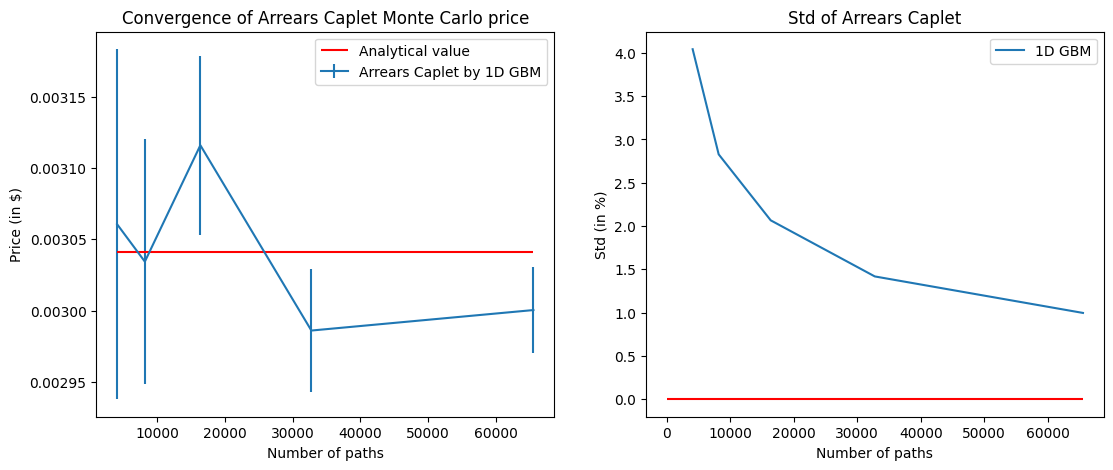

In [41]:
print(f'Using parameters: sigma = {sigma:.2f}, T0 = {T0:.2f} years, T1 = {T1:.2f} years, K = {K:.2f}')
fig,ax = plt.subplots(1,2, figsize=(13,5))

ax[0].errorbar(pathsArray, MC_ArrearsCapletpricer_PT0, yerr = MC_ArrearsCapletpricer_PT0_Std, label = f'Arrears Caplet by 1D GBM')
ax[1].plot(pathsArray, MC_ArrearsCapletpricer_PT0_Std*100/numericArrearsCaplet, label = "1D GBM")

ax[0].set_title('Convergence of Arrears Caplet Monte Carlo price')
ax[0].set_xlabel('Number of paths')
ax[0].hlines(xmin = pathsArray[0], xmax = pathsArray[-1], y =numericArrearsCaplet, color = 'red', label='Analytical value')
ax[0].legend()
ax[0].set_ylabel(r'Price (in \$)')
ax[1].set_title('Std of Arrears Caplet')
ax[1].set_xlabel('Number of paths')
ax[1].set_ylabel(r'Std (in %)')
ax[1].hlines(y=0, color = 'red', xmin =0, xmax = np.power(2,maxPower-1))
ax[1].legend()
fig.show()